# Character RNN Classifier

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
import csv
import re
import pylab
import matplotlib.pyplot as plt

In [2]:
MAX_DOCUMENT_LENGTH = 100
HIDDEN_SIZE = 20
MAX_LABEL = 15

batch_size = 128
one_hot_size = 256
no_epochs = 100
lr = 0.01

seed = 10
tf.random.set_seed(seed)


## Read data

In [3]:
# Read data with [character]
def vocabulary(strings):
    chars = sorted(list(set(list(''.join(strings)))))
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    vocab_size = len(chars)
    return vocab_size, char_to_ix

In [4]:
def preprocess(strings, char_to_ix, MAX_LENGTH):
    data_chars = [list(d.lower()) for _, d in enumerate(strings)]
    for i, d in enumerate(data_chars):
        if len(d)>MAX_LENGTH:
            d = d[:MAX_LENGTH]
        elif len(d) < MAX_LENGTH:
            d += [' '] * (MAX_LENGTH - len(d))
            
    data_ids = np.zeros([len(data_chars), MAX_LENGTH], dtype=np.int64)
    for i in range(len(data_chars)):
        for j in range(MAX_LENGTH):
            data_ids[i, j] = char_to_ix[data_chars[i][j]]
    return np.array(data_ids)

In [5]:
def read_data_chars():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('/content/drive/My Drive/tensorflow/train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('/content/drive/My Drive/tensorflow/test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))

    vocab_size, char_to_ix = vocabulary(x_train+x_test)
    x_train = preprocess(x_train, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    return x_train, y_train, x_test, y_test

In [6]:
x_train, y_train, x_test, y_test = read_data_chars()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

## Build model

In [7]:
# Build model
tf.keras.backend.set_floatx('float32')
class CharRNN(Model):

    def __init__(self, vocab_size, hidden_dim=10):
        super(CharRNN, self).__init__()
        # Hyperparameters
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        # Weight variables and RNN cell
        self.rnn = layers.RNN(tf.keras.layers.GRUCell(self.hidden_dim), unroll=True) # GRU
        #self.rnn2 = layers.RNN(tf.keras.layers.GRUCell(self.hidden_dim), unroll=True) # GRU2
        #self.rnn = layers.RNN(tf.keras.layers.SimpleRNNCell(self.hidden_dim), unroll=True) # Vanilla RNN
        #self.rnn = layers.RNN(tf.keras.layers.LSTMCell(self.hidden_dim), unroll=True) # LSTM
        self.dense = layers.Dense(MAX_LABEL, activation='softmax')

    def call(self, x, drop_rate):
        # forward logic
        x = tf.one_hot(x, one_hot_size)
        encoding = self.rnn(x)
        #encoding = self.rnn2(encoding)
        #encoding = tf.nn.dropout(encoding, drop_rate) 
        logits = self.dense(encoding)
    
        return logits

In [8]:
model = CharRNN(256, HIDDEN_SIZE)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipvalue = 2) # Gradient Clipping

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


## Functions for training and testing

In [9]:
# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

In [10]:
# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

## Train model

In [11]:
test_acc = []
train_lo = []
for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    test_acc.append(test_accuracy.result())
    train_lo.append(train_loss.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))

Epoch 1, Loss: 2.6424436569213867, Accuracy: 0.08749999850988388, Test Loss: 2.599637746810913, Test Accuracy: 0.11571428924798965
Epoch 2, Loss: 2.582338571548462, Accuracy: 0.11821428686380386, Test Loss: 2.5360214710235596, Test Accuracy: 0.11428571492433548
Epoch 3, Loss: 2.3481719493865967, Accuracy: 0.18535713851451874, Test Loss: 2.2858169078826904, Test Accuracy: 0.20571428537368774
Epoch 4, Loss: 2.096890687942505, Accuracy: 0.2596428692340851, Test Loss: 2.0515949726104736, Test Accuracy: 0.2914285659790039
Epoch 5, Loss: 1.8945132493972778, Accuracy: 0.33250001072883606, Test Loss: 1.8233146667480469, Test Accuracy: 0.36142855882644653
Epoch 6, Loss: 1.641984462738037, Accuracy: 0.4348214268684387, Test Loss: 1.5899138450622559, Test Accuracy: 0.4528571367263794
Epoch 7, Loss: 1.4462507963180542, Accuracy: 0.4982142746448517, Test Loss: 1.4201141595840454, Test Accuracy: 0.5042856931686401
Epoch 8, Loss: 1.3080333471298218, Accuracy: 0.550000011920929, Test Loss: 1.357061743

## Plot accuracy and loss curves

Text(0, 0.5, 'Train Loss')

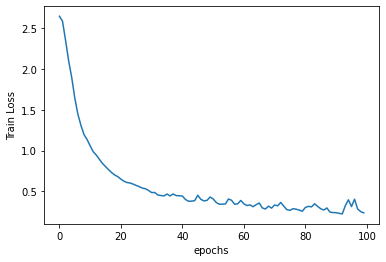

In [12]:
# Plot train loss
pylab.figure()
pylab.plot(np.arange(no_epochs), train_lo)
pylab.xlabel('epochs')
pylab.ylabel('Train Loss')

Text(0, 0.5, 'Test Accuracy')

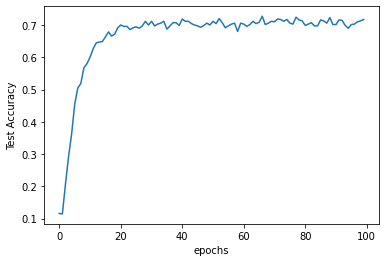

In [13]:
# Plot test accuracy
pylab.figure()
pylab.plot(np.arange(no_epochs), test_acc)
pylab.xlabel('epochs')
pylab.ylabel('Test Accuracy')